<a href="https://colab.research.google.com/github/crbsdndr/animal_detection/blob/main/animal_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyek Klasifikasi Gambar: [Animal Faces](https://www.kaggle.com/datasets/andrewmvd/animal-faces)**
- **Nama:** Mochamad Dendra Dwi Pratama Putra
- **Email:** artrialazz@gmail.com
- **ID Dicoding:** @crbsdndr

## **Import Semua Packages/Library yang Digunakan**

In [41]:
!pip install tensorflowjs
!pip install -q kaggle
!pip install tensorflow
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 96.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found e

In [73]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input, models, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import files
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os

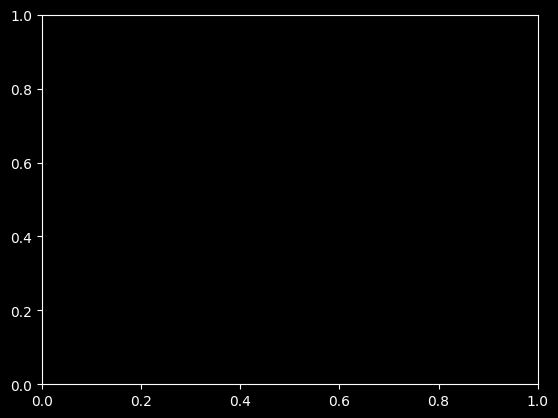

In [3]:
plt.style.use('dark_background')
ax = plt.axes()
ax.set_facecolor('black')

## **Data Preparation**

### **Data Loading**

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"crbsdndr","key":"1e4e389cd67dbaac8dd48bfbfdd1a73f"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d andrewmvd/animal-faces --force
!unzip "/content/animal-faces.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/afhq/train/wild/flickr_wild_001378.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001379.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001380.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001381.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001382.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001384.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001385.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001386.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001387.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001388.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001389.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001390.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001391.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001392.jpg  
  inflating: /content/afhq/train/wild/flickr_wild_001393.jpg  
  in

In [7]:
os.rename("/content/afhq", "/content/animal")
os.rename("/content/animal/val", "/content/animal/validation")

In [8]:
DATA_PATH = "/content/animal"

def collect_data(data_path: str) -> tuple:
    X_data = []
    y_data = []

    valid_use_cases = ["train", "validation"]

    for use_case in valid_use_cases:
        use_case_path = os.path.join(data_path, use_case)

        if not os.path.exists(use_case_path):
            continue

        for animal_name in os.listdir(use_case_path):
            animal_path = os.path.join(use_case_path, animal_name)

            if os.path.isdir(animal_path):
                image_paths = [
                    os.path.join(animal_path, img)
                    for img in os.listdir(animal_path)
                    if os.path.isfile(os.path.join(animal_path, img))
                ]

                X_data.extend(image_paths)
                y_data.extend([animal_name] * len(image_paths))

    return np.array(X_data), np.array(y_data)
X, y = collect_data(data_path=DATA_PATH)

### **Data Preprocessing**

In [9]:
def undersample(*, data_path: np.ndarray, labels_path: np.ndarray) -> np.ndarray:
    unique_classes, counts = np.unique(labels_path, return_counts=True)
    minority_values = unique_classes[counts == np.min(counts)]
    min_count = np.min(counts)
    keep_indices = []
    for label in unique_classes:
        indices = np.where(labels_path == label)[0]

        if label in minority_values:
            keep_indices.extend(indices)
        else:
            keep_indices.extend(indices[:min_count])

    keep_indices = np.sort(np.array(keep_indices))
    undersampled_images_path = data_path[keep_indices]
    undersampled_labels = labels_path[keep_indices]

    return undersampled_images_path, undersampled_labels

X_undersampled, y_undersampled = undersample(data_path=X, labels_path=y)

In [10]:
def grayscale(*, storage_path: str, data_path: np.ndarray, labels_path: np.ndarray) -> np.ndarray:
    os.makedirs(storage_path, exist_ok=True)

    all_labels = set(np.unique(labels_path))
    for label in all_labels:
        os.makedirs(os.path.join(storage_path, str(label)), exist_ok=True)

    new_paths = np.empty(len(data_path), dtype=object)

    label_indices = {}
    for label in np.unique(labels_path):
        label_indices[label] = np.where(labels_path == label)[0]

    for label, indices in label_indices.items():
        total_images = len(indices)
        label_dir = os.path.join(storage_path, str(label))

        for count, idx in enumerate(indices, 1):
            img_path = data_path[idx]
            file_name = os.path.basename(img_path)
            new_img_path = os.path.join(label_dir, file_name)

            if os.path.isfile(new_img_path):
                print(f"File {file_name} with path {new_img_path} already exists, skip it {count} / {total_images}")
            else:
                img = cv2.imread(img_path)
                if img is not None:
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    cv2.imwrite(new_img_path, gray_img)
                    print(f"Created image {count} of {total_images} with {label} in path {new_img_path}")
                else:
                    print(f"Error: Cannot read image {img_path}")

            new_paths[idx] = os.path.abspath(new_img_path)

    return new_paths

os.makedirs("/content/animal/grayscaled", exist_ok=True)
storage_path = "/content/animal/grayscaled"

X_grayscaled = grayscale(
    storage_path=storage_path, data_path=X_undersampled, labels_path=y_undersampled
)
y_grayscaled = y_undersampled.copy()

Streaming output truncated to the last 5000 lines.
Created image 239 of 5238 with wild in path /content/animal/grayscaled/wild/flickr_wild_002600.jpg
Created image 240 of 5238 with wild in path /content/animal/grayscaled/wild/flickr_wild_000665.jpg
Created image 241 of 5238 with wild in path /content/animal/grayscaled/wild/flickr_wild_003285.jpg
Created image 242 of 5238 with wild in path /content/animal/grayscaled/wild/flickr_wild_002890.jpg
Created image 243 of 5238 with wild in path /content/animal/grayscaled/wild/flickr_wild_001738.jpg
Created image 244 of 5238 with wild in path /content/animal/grayscaled/wild/pixabay_wild_001204.jpg
Created image 245 of 5238 with wild in path /content/animal/grayscaled/wild/flickr_wild_003819.jpg
Created image 246 of 5238 with wild in path /content/animal/grayscaled/wild/flickr_wild_002105.jpg
Created image 247 of 5238 with wild in path /content/animal/grayscaled/wild/flickr_wild_000462.jpg
Created image 248 of 5238 with wild in path /content/anim

In [11]:
def prepare(*, data_path: np.ndarray):
    def process_image(*, data_path: np.ndarray):
        X_read = tf.io.read_file(data_path)
        X_decoded = tf.image.decode_jpeg(X_read, channels=1)
        X_resized = tf.image.resize(X_decoded, [128, 128])
        return X_resized

    X_processed = [process_image(data_path=path) for path in data_path]
    X_stacked = tf.stack(X_processed)
    return X_stacked

X_prepared = prepare(data_path=X_grayscaled)

In [12]:
y_encoder = LabelEncoder()

y_total_unique = len(np.unique(y_grayscaled))
y_encoded = y_encoder.fit_transform(y_grayscaled)

y_categorized = to_categorical(y_encoded, y_total_unique)

#### **Split Dataset**

In [13]:
def split(*, data, labels, train_size, validation_size, test_size):
    total_size = train_size + validation_size + test_size
    if total_size != 1:
        raise ValueError(f"Total of train_size, val_size, and test_size must be 1. But received {total_size}")

    dataset = tf.data.Dataset.from_tensor_slices((data, labels)).shuffle(buffer_size=len(data), seed=42)

    total_count = len(data)
    train_count = int(train_size * total_count)
    validation_count = int(validation_size * total_count)

    train_dataset = dataset.take(train_count)
    remaining_dataset = dataset.skip(train_count)
    validation_dataset = remaining_dataset.take(validation_count)
    test_dataset = remaining_dataset.skip(validation_count)

    X_train, y_train = tf.data.experimental.get_single_element(train_dataset.batch(train_count))
    X_validation, y_validation = tf.data.experimental.get_single_element(validation_dataset.batch(validation_count))
    X_test, y_test = tf.data.experimental.get_single_element(test_dataset.batch(total_count - train_count - validation_count))

    return X_train, X_validation, X_test, y_train, y_validation, y_test

X_train, X_validation, X_test, y_train, y_validation, y_test = split(
    data=X_prepared, labels=y_categorized, train_size=0.7, validation_size=0.15, test_size=0.15
)


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


### **Data Visualization**

In [14]:
print(f"Variable train data type X             :", type(X))
print(f"Variable validation data type y        :", type(y))

print(f"Variable content train data type X     :", X.dtype)
print(f"Variable content validation data type y:", y.dtype)

Variable train data type X             : <class 'numpy.ndarray'>
Variable validation data type y        : <class 'numpy.ndarray'>
Variable content train data type X     : <U55
Variable content validation data type y: <U4


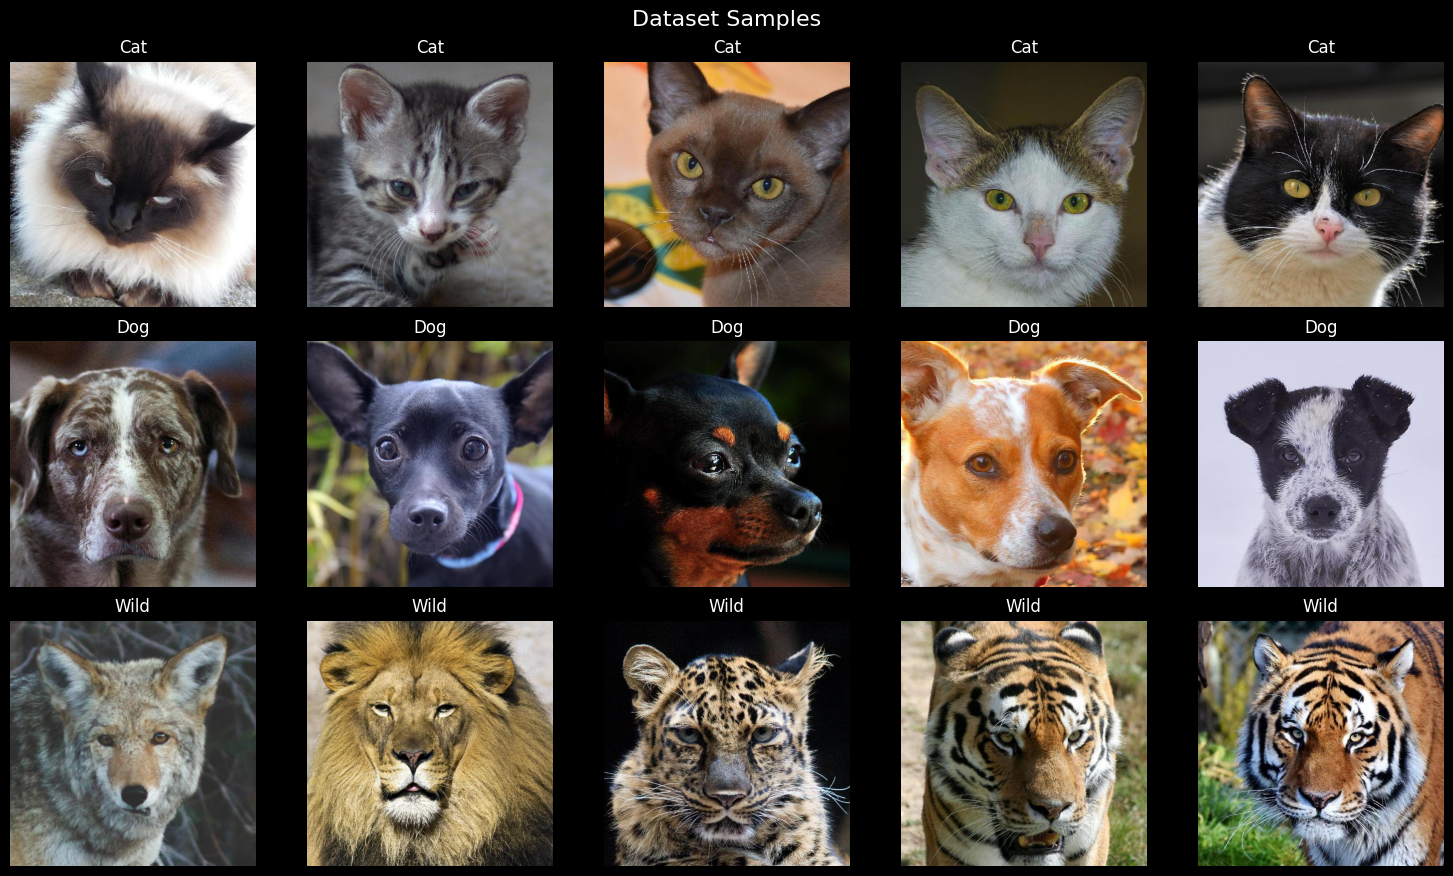

In [15]:
def visualize_samples(*, data_path: np.ndarray, labels_path: np.ndarray, total_column: np.ndarray) -> None:
    unique_labels = np.unique(labels_path)
    total_labels = len(unique_labels)

    fig = plt.figure(figsize=(total_column*3, total_labels*3))

    for i, label in enumerate(unique_labels):
        indices = np.where(labels_path == label)[0]
        n_available = len(indices)

        selected_indices = np.random.choice(indices, min(total_column, n_available), replace=False) if n_available > 0 else []

        for j in range(min(total_column, len(selected_indices))):
            position = i * total_column + j + 1

            ax = fig.add_subplot(total_labels, total_column, position)

            idx = selected_indices[j]
            img = plt.imread(data_path[idx])
            ax.imshow(img, cmap='gray')
            ax.set_title(f"{label.capitalize()}")
            ax.axis('off')

    plt.figtext(0.5, 0.95, "Dataset Samples", fontsize=16, ha="center")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


visualize_samples(data_path=X, labels_path=y, total_column=5)

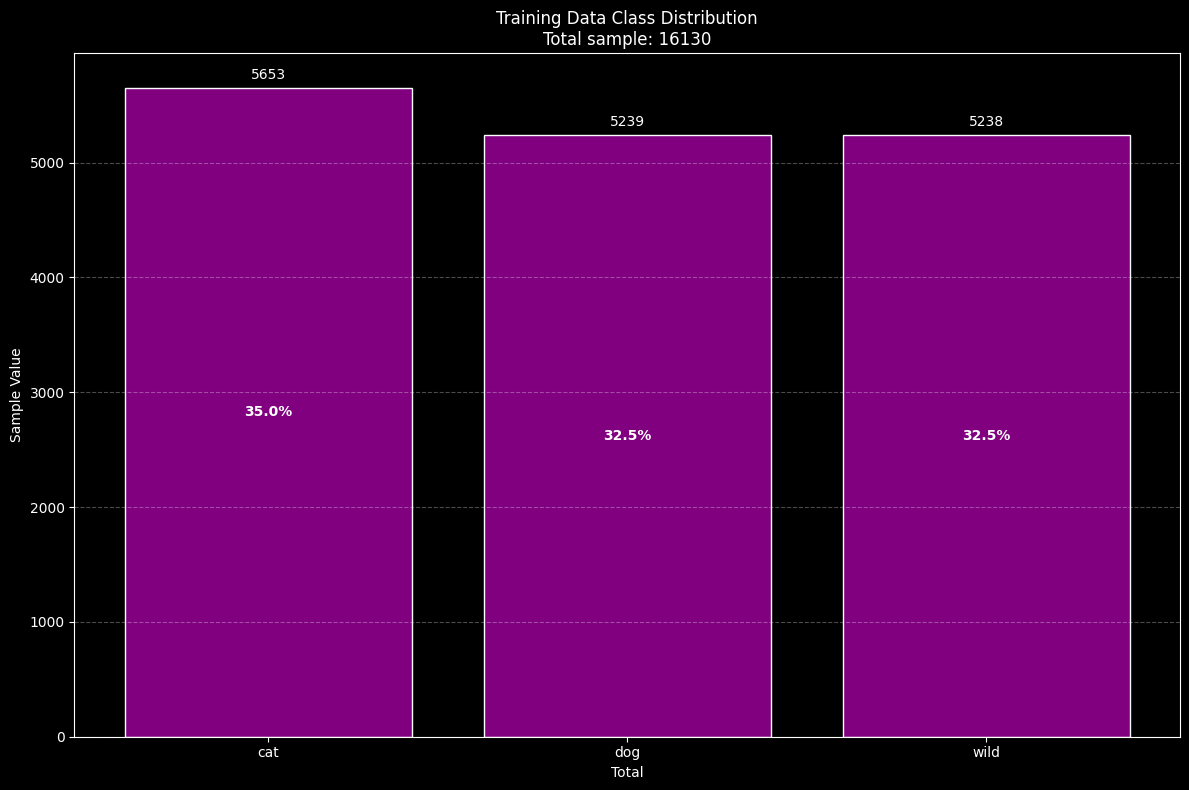

In [16]:
def plot_class_distribution(*, labels_path: np.ndarray, title: str) -> None:
    plt.figure(figsize=(12, 8))

    label_counts = Counter(labels_path)
    unique_labels = sorted(label_counts.keys())
    counts = [label_counts[label] for label in unique_labels]

    bars = plt.bar(unique_labels, counts, color="purple", edgecolor="white")

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2., height + 50,
            f"{count}", ha="center", va="bottom", color="white"
        )

    total_samples = sum(counts)
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        percentage = (count / total_samples) * 100
        plt.text(
            bar.get_x() + bar.get_width()/2., height/2,
            f'{percentage:.1f}%', ha="center", va='center',
            color='white', fontweight='bold'
        )

    plt.xlabel("Total", color="white")
    plt.ylabel("Sample Value", color="white")
    plt.title(f"{title}\nTotal sample: {total_samples}", color="white")
    plt.xticks(unique_labels, color="white")
    plt.yticks(color="white")
    plt.grid(axis='y', linestyle='--', alpha=0.3, color="white")

    plt.ylim(0, max(counts) + 300)
    plt.tight_layout()
    plt.show()

plot_class_distribution(labels_path=y, title="Training Data Class Distribution")

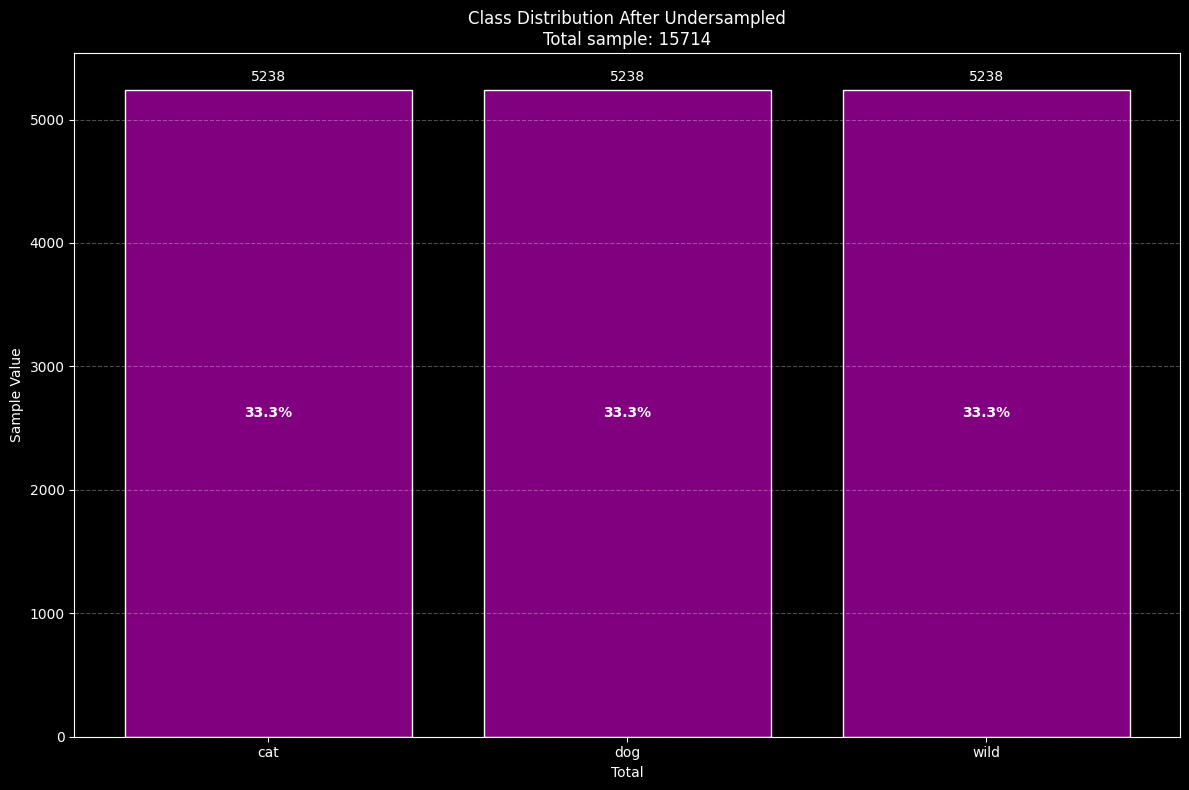

In [17]:
plot_class_distribution(labels_path=y_undersampled, title="Class Distribution After Undersampled")

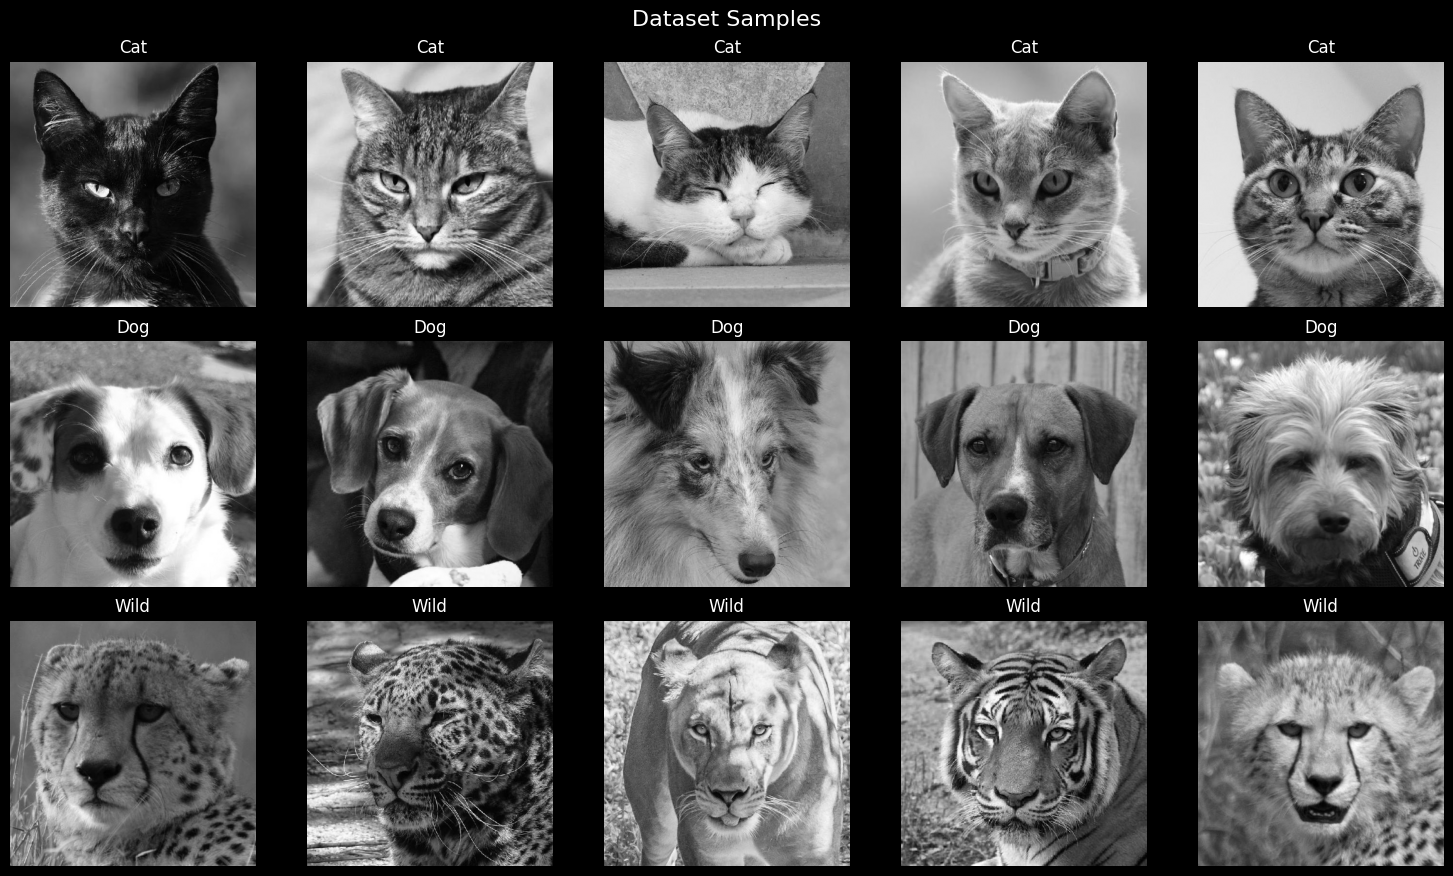

In [18]:
visualize_samples(data_path=X_grayscaled, labels_path=y_grayscaled, total_column=5)

## **Modelling**

In [19]:
def build_model(*, input_shape, total_labels):
    model = Sequential([
        Conv2D(32, (3, 3), padding="same", kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(total_labels, activation="softmax")
    ])

    return model

def compile_model(*, model):
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss="categorical_crossentropy",
        metrics=["accuracy"])

def train_model(*, model, X_train, y_train, X_validation, y_validation, epochs=30, batch_size=64):
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.001,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=2,
        min_lr=0.00001
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        callbacks=[early_stopping, reduce_lr]
    )
    return history

def evaluate_model(model, X_test, y_test, class_names=None):
    loss, accuracy = model.evaluate(X_test, y_test)

    predictions = model.predict(X_test, verbose=0)

    if len(y_test.shape) > 1:
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(predictions, axis=1)
    else:
        y_true = y_test
        y_pred = (predictions > 0.5).astype(int).flatten()

    conf_matrix = confusion_matrix(y_true, y_pred)

    precision_value = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_value = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print("=== Model Evaluation Report ===")
    print(f"Loss           : {loss:.4f}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision_value:.4f}")
    print(f"Recall         : {recall_value:.4f}")
    print(f"F1-Score       : {f1:.4f}")

    print("\nClassification Report:")
    if class_names:
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    else:
        print(classification_report(y_true, y_pred, digits=4))

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(conf_matrix))
    plt.xticks(tick_marks, class_names if class_names else tick_marks, fontsize=12)
    plt.yticks(tick_marks, class_names if class_names else tick_marks, fontsize=12)

    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black",
                     fontsize=12)

    plt.ylabel('Label Sebenarnya', fontsize=14)
    plt.xlabel('Label Prediksi', fontsize=14)

    plt.tight_layout()
    plt.show()

In [20]:
model = build_model(input_shape=X_train[0].shape, total_labels=len(np.unique(y_undersampled)))
compile_model(model=model)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
history = train_model(
    model=model, X_train=X_train, y_train=y_train,
    X_validation=X_validation, y_validation=y_validation
)

Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - accuracy: 0.5902 - loss: 6.2702 - val_accuracy: 0.8676 - val_loss: 0.5052 - learning_rate: 5.0000e-04
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8358 - loss: 0.5677 - val_accuracy: 0.7900 - val_loss: 0.6178 - learning_rate: 5.0000e-04
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8789 - loss: 0.4421 - val_accuracy: 0.8736 - val_loss: 0.4322 - learning_rate: 5.0000e-04
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9134 - loss: 0.3540 - val_accuracy: 0.9402 - val_loss: 0.2730 - learning_rate: 5.0000e-04
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9312 - loss: 0.3008 - val_accuracy: 0.9427 - val_loss: 0.2681 - learning_rate: 5.0000e-04
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9349 - loss: 0.2705 - val_accuracy: 0.9516 - val_loss: 0.2261 - learning_rate: 5.0000e-04
Epoch 7/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - ac

## **Evaluasi dan Visualisasi**

In [65]:
y_decoded = np.argmax(y_test, axis=1)
y_original = y_encoder.inverse_transform(y_decoded)

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9844 - loss: 0.1408
=== Model Evaluation Report ===
Loss           : 0.1256
Accuracy       : 0.9843
Precision      : 0.9844
Recall         : 0.9844
F1-Score       : 0.9844

Classification Report:
              precision    recall  f1-score   support

         cat     0.9896    0.9909    0.9903       769
         dog     0.9837    0.9788    0.9813       803
        wild     0.9797    0.9835    0.9816       786

    accuracy                         0.9843      2358
   macro avg     0.9844    0.9844    0.9844      2358
weighted avg     0.9843    0.9843    0.9843      2358



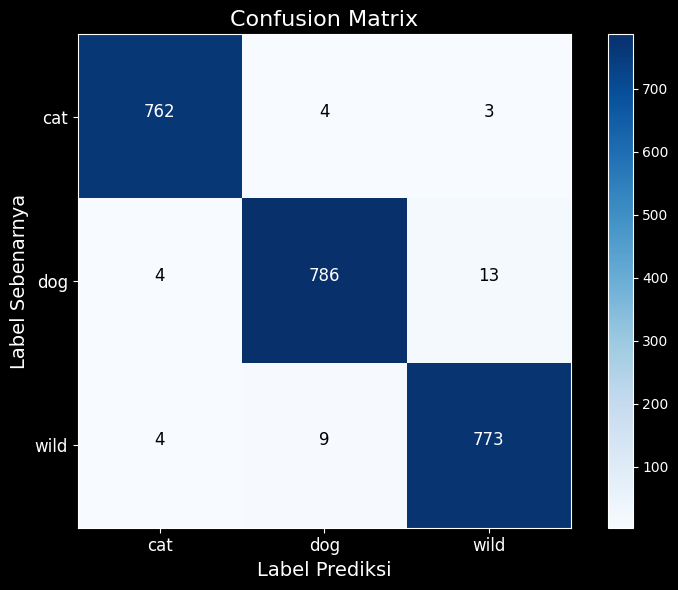

In [66]:
evaluate_model(model=model, X_test=X_test, y_test=y_test, class_names=list(np.unique(y_original)))

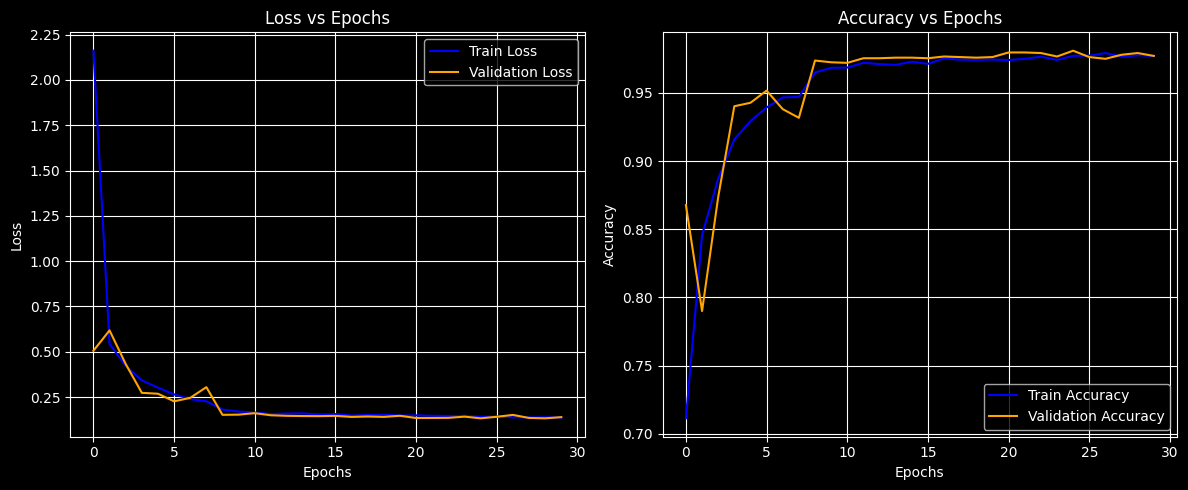

In [24]:
def plot_loss_accuracy(*, history):
    has_accuracy = 'accuracy' in history.history or 'acc' in history.history

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.grid()

    if has_accuracy:
        plt.subplot(1, 2, 2)
        accuracy_key = 'accuracy' if 'accuracy' in history.history else 'acc'
        val_accuracy_key = 'val_' + accuracy_key
        plt.plot(history.history[accuracy_key], label='Train Accuracy', color='blue')
        plt.plot(history.history[val_accuracy_key], label='Validation Accuracy', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Epochs')
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

plot_loss_accuracy(history=history)

## **Konversi Model**

### **SavedModel**

In [39]:
model_save_path = "./saved_model"
tf.saved_model.save(model, model_save_path)

### **Tensoflow-Lite**

In [40]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_save_path)
tflite_model = converter.convert()

with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

### **Tensoflow-JS**

In [48]:
print(model.layers[-1].name)

dense_1


In [42]:
os.makedirs("./tfjs", exist_ok=True)

In [49]:
!tensorflowjs_converter --input_format=tf_saved_model \
                        --output_node_names=dense_1 \
                        --saved_model_tags=serve \
                        ./saved_model \
                        ./tfjs

2025-04-03 05:38:29.631798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743658709.654946   14040 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743658709.661617   14040 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743658709.679160   14040 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743658709.679204   14040 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743658709.679207   14040 computation_placer.cc:177] computation placer alr

## **Inference (Optional)**

In [52]:
loaded_model = tf.saved_model.load(model_save_path)
predict_fn = loaded_model.signatures["serving_default"]

In [54]:
predictions = predict_fn(X_test)

Akurasi: 0.9843
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       769
           1       0.98      0.98      0.98       803
           2       0.98      0.98      0.98       786

    accuracy                           0.98      2358
   macro avg       0.98      0.98      0.98      2358
weighted avg       0.98      0.98      0.98      2358



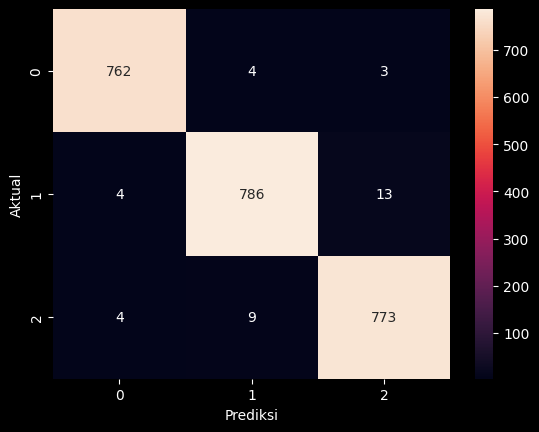

In [74]:
predicted_probabilities = predictions['output_0'].numpy()

y_pred = np.argmax(predicted_probabilities, axis=1)

akurasi = accuracy_score(y_decoded, y_pred)
print(f"Akurasi: {akurasi:.4f}")

print(classification_report(y_decoded, y_pred))
cm = confusion_matrix(y_decoded, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()